# Specialisation query using NSimplex
Simplex query for Peacocks.
Derived from matlab code: poly_query_peacock.mlx

In [53]:
import pathlib
from sisap2023.utils.mirflickr import load_encodings

sm_data = load_encodings(pathlib.Path('/Volumes/Data/mf_resnet50_softmax'))

# Load the data

data = load_encodings(pathlib.Path("/Volumes/Data/mf_dino2")) # load encodings

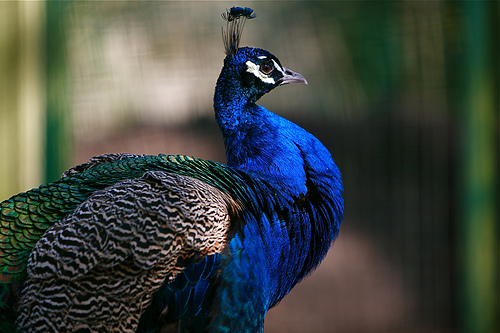

In [54]:
# Get the peacock at index 

from sisap2023.utils.mirflickr import get_mf_image

q0 = 101102 # a peacock

get_mf_image(q0)

In [55]:
from sisap2023.metrics.euc import euc

def getDists(query_index,allData):
    '''Return the distances from the query to allData'''
    '''Returns an array same dimension as allData of scalars'''
    mf_query_data = allData[query_index]
    distances = euc(mf_query_data, allData)
    return distances

In [56]:
from matplotlib import pyplot as plt

def imShow( image ):
    # plt.title(Image title")
    #plt.xlabel("X pixel scaling")
    # plt.ylabel("Y pixels scaling")

    fig = plt.figure(figsize = (1,1)) # in inches!
    plt.axis('off')
    plt.imshow(image) # figsize=(640/80,640/80), dpi=80)
    plt.show()

In [57]:
dists = getDists(q0,data)
closest_indices = np.argsort(dists) # the closest images to the query
poly_query_indexes = closest_indices[0:6] # These are the indices we will use for the poly query
best_100_for_one = closest_indices[0:100]

In [59]:
from sisap2023.utils.count_cats import get_best_cats_in_subset

peacock_category = 84

best_100_categorical = get_best_cats_in_subset(peacock_category,best_100_for_one,sm_data)


In [60]:

print(dists[closest_indices[0:20]])
print(closest_indices[1]) # first index that is not the query

[ 0.       26.294218 27.029194 28.616566 28.819191 30.143585 30.277384
 30.441221 30.78398  30.948078 31.314728 31.433718 31.881916 33.109932
 33.255512 33.347916 33.39534  33.406166 33.632133 33.76943 ]
83692


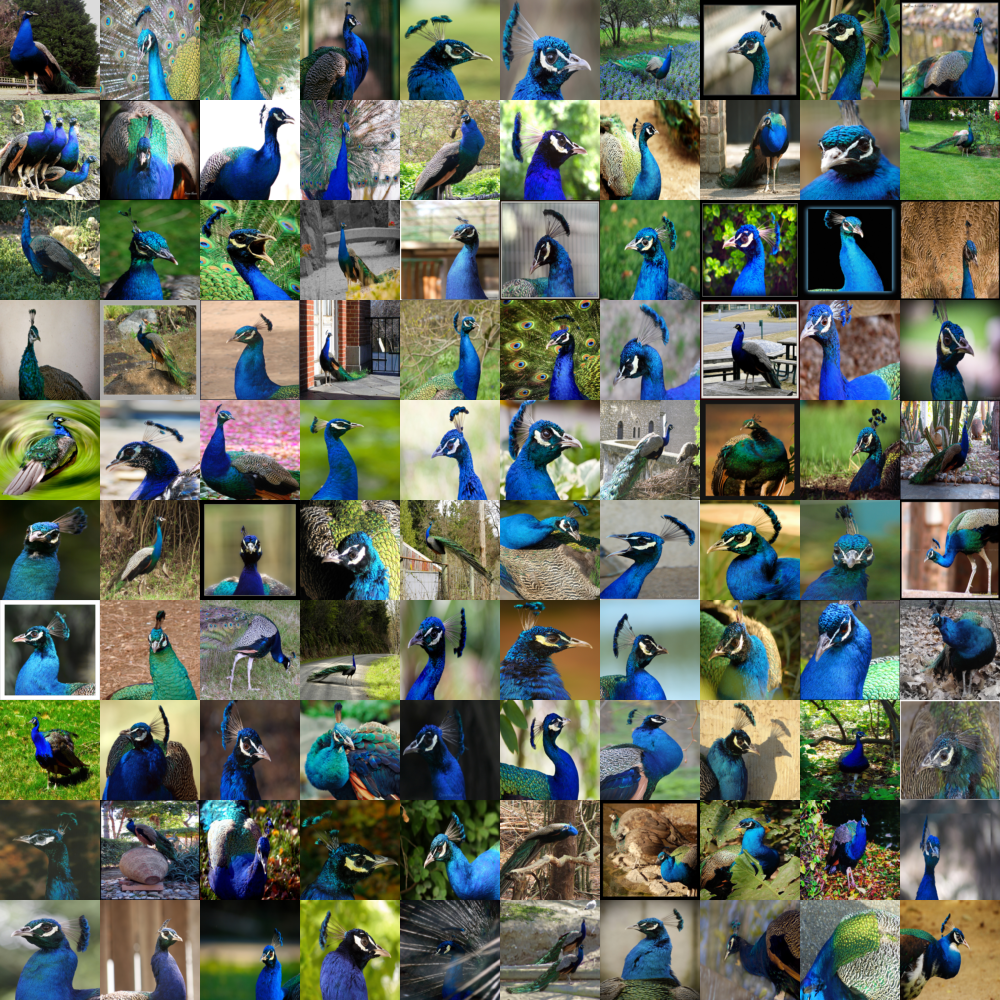

In [61]:
# These are the best images best on lowest average distance from the queries

from sisap2023.utils.mirflickr import make_mf_image_grid

make_mf_image_grid(best_100_categorical,10,10,100,100)

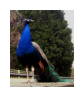

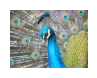

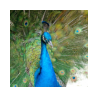

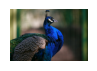

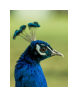

In [62]:


for i in range(0,5): # 0 is the original image
    imShow(get_mf_image(best_100_categorical[i]))

In [63]:

poly_query_indexes = best_100_categorical[0:5] # These are the indices we will use for the poly query

poly_query_data = data[poly_query_indexes]

In [64]:
import math 

def euc_scalar(p1: np.array, p2: np.array):
    distances = math.sqrt(np.sum((p1 - p2) ** 2))
    return distances

from sisap2023.metrics.nsimplex import NSimplex
import numpy as np

def fromSimplexPoint(poly_query_distances : np.array, inter_pivot_distances : np.array, nn_dists:  np.array) -> np.array:
    '''poly_query_data is the set of reference points with which to build the simplex'''
    '''inter_pivot_distances are the inter-pivot distances with which to build the base simplex'''
    '''nn_dists is a column vec of distances, each abit more than the nn distance from each ref to the rest of the data set'''
    '''ie the "perfect" intersection to the rest of the set'''
    '''returns a np.array of distances between the perfect point and the rest of the data set'''

    nsimp = NSimplex()
    nsimp.build_base(inter_pivot_distances,False)

    # second param a (B,N)-shaped array containing distances to the N pivots for B objects.
    perfPoint = nsimp._get_apex(nsimp._base,nn_dists)    # was projectWithDistances in matlab

    for i in range(1000 * 1000):
        distvec = poly_query_distances[:,i];                      # a row vec of distances
        pr = nsimp._get_apex(nsimp._base,np.transpose(distvec));
        dists[i] = euc_scalar(pr,perfPoint)

    return dists


In [65]:
# from Italian documentation: README.md line 25
from scipy.spatial.distance import pdist, squareform

inter_pivot_distances = squareform(pdist(poly_query_data, metric=euc_scalar)) # pivot-pivot distance matrix with shape (n_pivots, n_pivots)

In [66]:
# Fetch the data and whole-set distances for the extra query objects
# fc6_poly_queries is the FC6 data for the queries we have chosen - not needed
# poly_query_distances is the distances from the queries to the all data 1000000,6

num_poly_queries = len(poly_query_indexes)

poly_query_distances = np.zeros((num_poly_queries,1000*1000))
for i in range(num_poly_queries):
    poly_query_distances[i] = getDists(poly_query_indexes[i],data) 

print(num_poly_queries)
print(poly_query_data.shape)
print(poly_query_distances.shape)

5
(5, 384)
(5, 1000000)


In [67]:
print(poly_query_indexes)
print(poly_query_distances.shape)
print(poly_query_distances)
print(inter_pivot_distances)

[789165 794045 845875 101102 812638]
(5, 1000000)
[[66.57473755 69.69219208 64.37290955 ... 67.00415802 69.26437378
  68.66861725]
 [67.73526001 70.00285339 64.40897369 ... 64.75711823 68.80758667
  69.93431854]
 [68.42850494 69.42275238 65.47301483 ... 65.11656189 68.33571625
  70.16652679]
 [67.66038513 72.4270401  66.99996948 ... 66.1264801  70.11083984
  69.80918884]
 [68.21811676 71.94100952 66.96607208 ... 64.36840057 68.98082733
  70.95846558]]
[[ 0.         42.08108831 38.70355552 34.29823816 43.52468067]
 [42.08108831  0.         18.60786295 42.55299717 39.22578373]
 [38.70355552 18.60786295  0.         38.9785833  36.72260286]
 [34.29823816 42.55299717 38.9785833   0.         36.3696906 ]
 [43.52468067 39.22578373 36.72260286 36.3696906   0.        ]]


### Simplex Projection

First calculate the distances from the queries to all data as we will be needing them again

In [68]:
nsimp = NSimplex()
nsimp.build_base(inter_pivot_distances,False)
# print(xx._base.shape)
# print(xx._base)
# print(inter_pivot_distances.shape)
# print(inter_pivot_distances)

In [69]:
# Next, find last coord from the simplex formed by 6 query points

all_apexes = nsimp._get_apex(nsimp._base,np.transpose(poly_query_distances))
altitudes = all_apexes[:,num_poly_queries -1] # the heights of the simplex - last coordinate


/Users/al/repos/sisap2023/sisap2023/metrics/nsimplex.py:43: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt((y_n ** 2) - (w ** 2))
/Users/al/repos/sisap2023/sisap2023/metrics/nsimplex.py:48: UserWarning: one or more points does not satisfies the n-point property, or the max dim was reached (diff for vertex-pivot 1 is [3988.12659545 4138.02643185 3651.59059818 ... 3572.32495694 3995.55297431
 4183.91221482])
  warnings.warn(f"one or more points does not satisfies the n-point property, or the max dim was reached (diff for vertex-pivot {k} is {diff})")
/Users/al/repos/sisap2023/sisap2023/metrics/nsimplex.py:48: UserWarning: one or more points does not satisfies the n-point property, or the max dim was reached (diff for vertex-pivot 2 is [2264.16893168 2166.71871996 2182.63653806 ... 2089.31662805 2135.09366085
 2282.66979951])
  warnings.warn(f"one or more points does not satisfies the n-point property, or the max dim was reached (diff for vertex-pivot {k} is {diff})")
/Us

[ 0.          0.          0.          0.          0.         11.63162783
 11.96708528 12.73838469 12.95280382 13.42441171 13.44063402 13.697275
 13.95405477 13.95792755 14.0725388  14.23764895 14.28574332 14.35755759
 14.93252173 15.04140059 15.30186387 15.35335055 15.45915137 15.46349756
 15.48408484 15.762705   15.80796304 16.02294761 16.06663235 16.11309641
 16.37601067 16.37989808 16.38665115 16.43557903 16.62575532 16.79102401
 16.90216052 17.01652272 17.07296878 17.10501549 17.35926664 17.59482576
 17.7837568  18.28514058 18.37498402 18.51658094 18.53763984 18.57676739
 18.65549619 18.73288615 18.86753928 19.06006428 19.06287389 19.51030269
 19.59296133 19.70133088 19.72343963 20.15340828 20.25108569 20.42263812
 20.42366474 20.65763342 20.73163409 20.75490453 20.7576297  20.92462265
 20.99214181 20.99441434 21.13162711 21.17218951 21.25205204 21.45312684
 21.48608827 21.51786688 21.57990705 21.62961537 21.64586633 21.9717131
 22.19762985 22.24510432 22.29972674 22.31892084 22.35

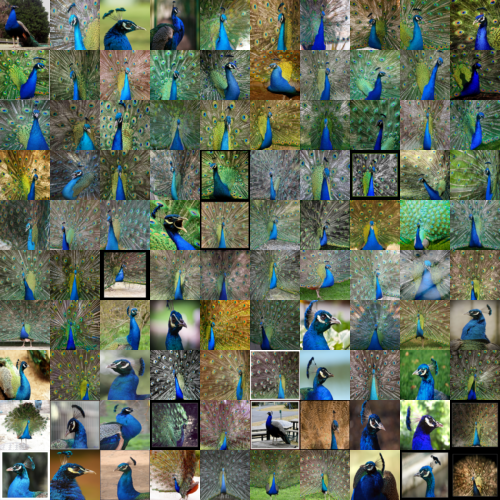

In [70]:
closest_indices = np.argsort(altitudes) # the closest images to the perfect point
print( altitudes[closest_indices][:100] )

best_100_for_simplex = closest_indices[0:100]

make_mf_image_grid(best_100_for_simplex,10,10,50,50)

In [71]:
# Now want to report results the total count in the category

from sisap2023.utils.count_cats import count_number_in_results_in_cat

encodings_for_best_100_single = softmax_encodings[best_100_for_one] # the alexnet encodings for the best 100 average singlequery images
single_peacock_totals = encodings_for_best_100_single[:,peacock_category]
print("Total peacock sum for single query best 100: ", np.sum(single_peacock_totals))


encodings_for_best_100_average = softmax_encodings[best_100_for_simplex] # the alexnet encodings for the best 100 polyquery images
average_peacock_totals = encodings_for_best_100_average[:,peacock_category]
print("Total peacock sum for poly query best 100: ", np.sum(average_peacock_totals))

res = count_number_in_results_in_cat(peacock_category,0.9,best_100_for_one,softmax_encodings)
print("Total with thresh better than 0.9 single query : ", res)

res = count_number_in_results_in_cat(peacock_category,0.9,best_100_for_simplex,softmax_encodings)
print("Total with thresh better than 0.9 poly query : ", res)

Total peacock sum for single query best 100:  93.58573884889483
Total peacock sum for poly query best 100:  94.42608266603202
Total with thresh better than 0.9 single query :  85
Total with thresh better than 0.9 poly query :  93
